In [47]:
#Import all the required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [48]:
###1.Data Preprocessing and Exploration
print("Step 1: Data Preprocessing and Exploration")

Step 1: Data Preprocessing and Exploration



Missing values in dataset:
MFCCs_ 1    0
MFCCs_ 2    0
MFCCs_ 3    0
MFCCs_ 4    0
MFCCs_ 5    0
MFCCs_ 6    0
MFCCs_ 7    0
MFCCs_ 8    0
MFCCs_ 9    0
MFCCs_10    0
MFCCs_11    0
MFCCs_12    0
MFCCs_13    0
MFCCs_14    0
MFCCs_15    0
MFCCs_16    0
MFCCs_17    0
MFCCs_18    0
MFCCs_19    0
MFCCs_20    0
MFCCs_21    0
MFCCs_22    0
Family      0
Genus       0
Species     0
RecordID    0
dtype: int64

Basic statistics of the dataset:
          MFCCs_ 1     MFCCs_ 2     MFCCs_ 3     MFCCs_ 4     MFCCs_ 5  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000   
mean      0.989885     0.323584     0.311224     0.445997     0.127046   
std       0.069016     0.218653     0.263527     0.160328     0.162722   
min      -0.251179    -0.673025    -0.436028    -0.472676    -0.636012   
25%       1.000000     0.165945     0.138445     0.336737     0.051717   
50%       1.000000     0.302184     0.274626     0.481463     0.161361   
75%       1.000000     0.466566     0.43069

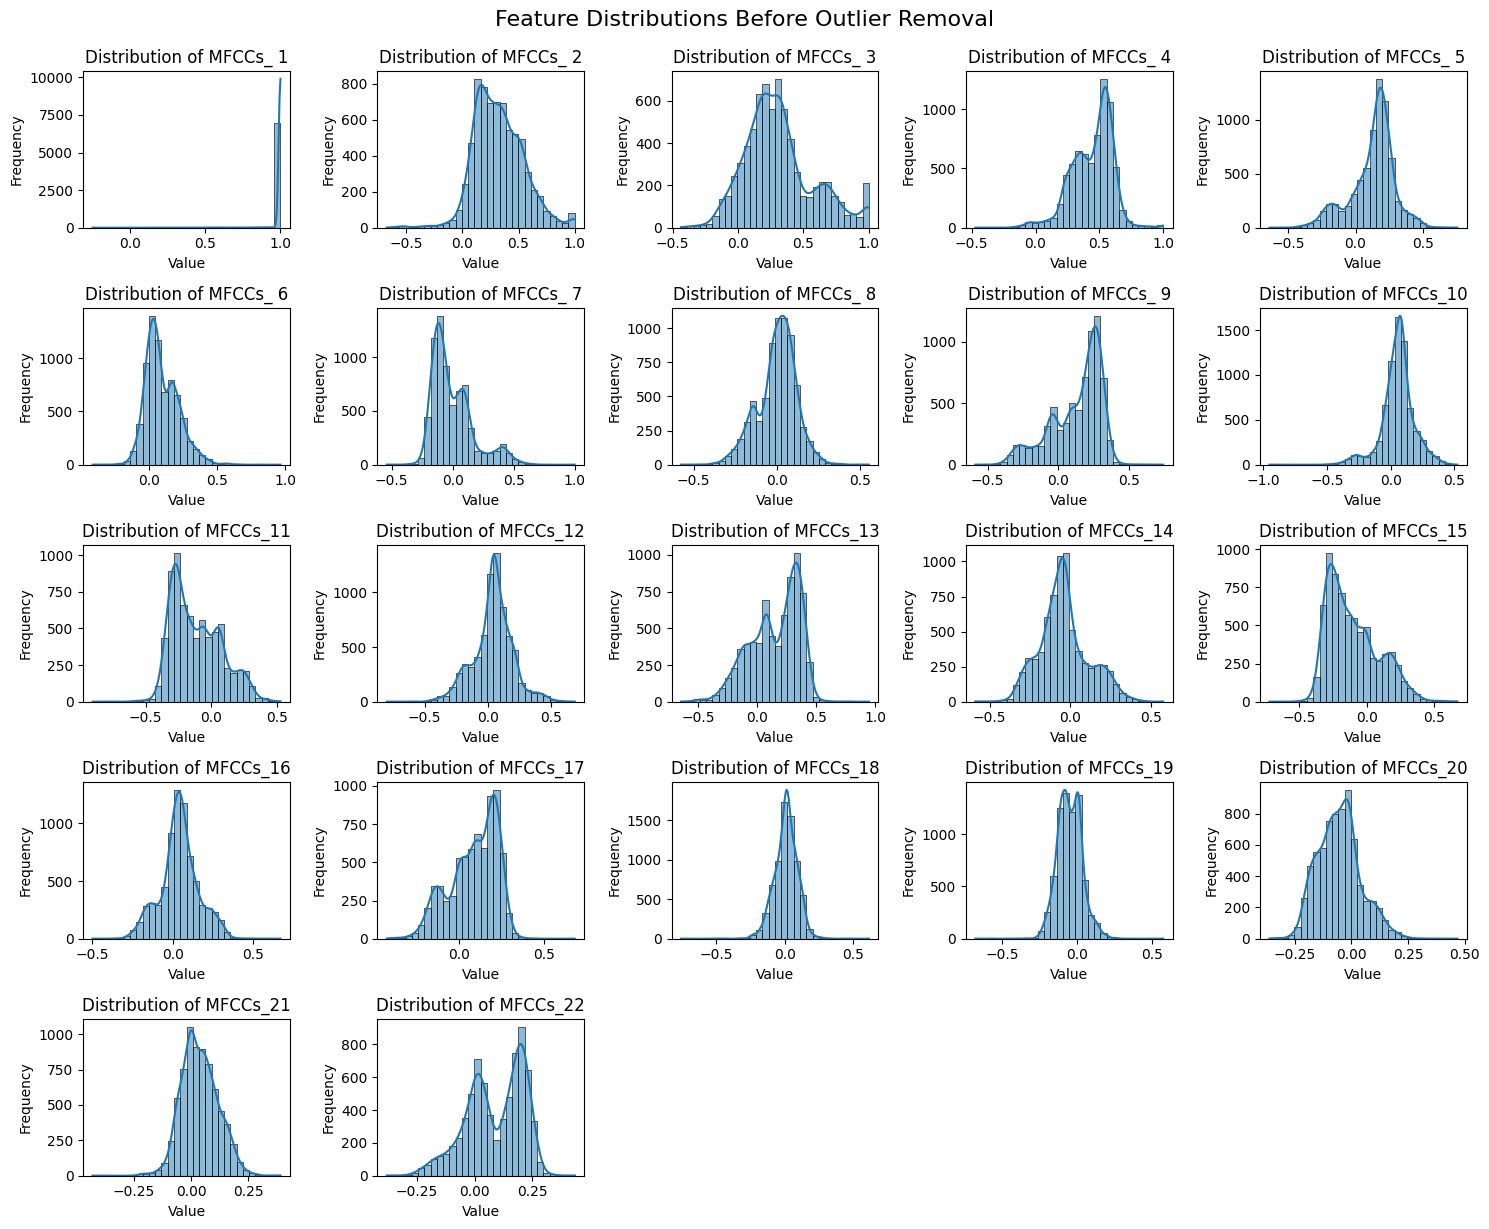

Original dataset size: 7195 rows
Dataset size after outlier removal: 4352 rows


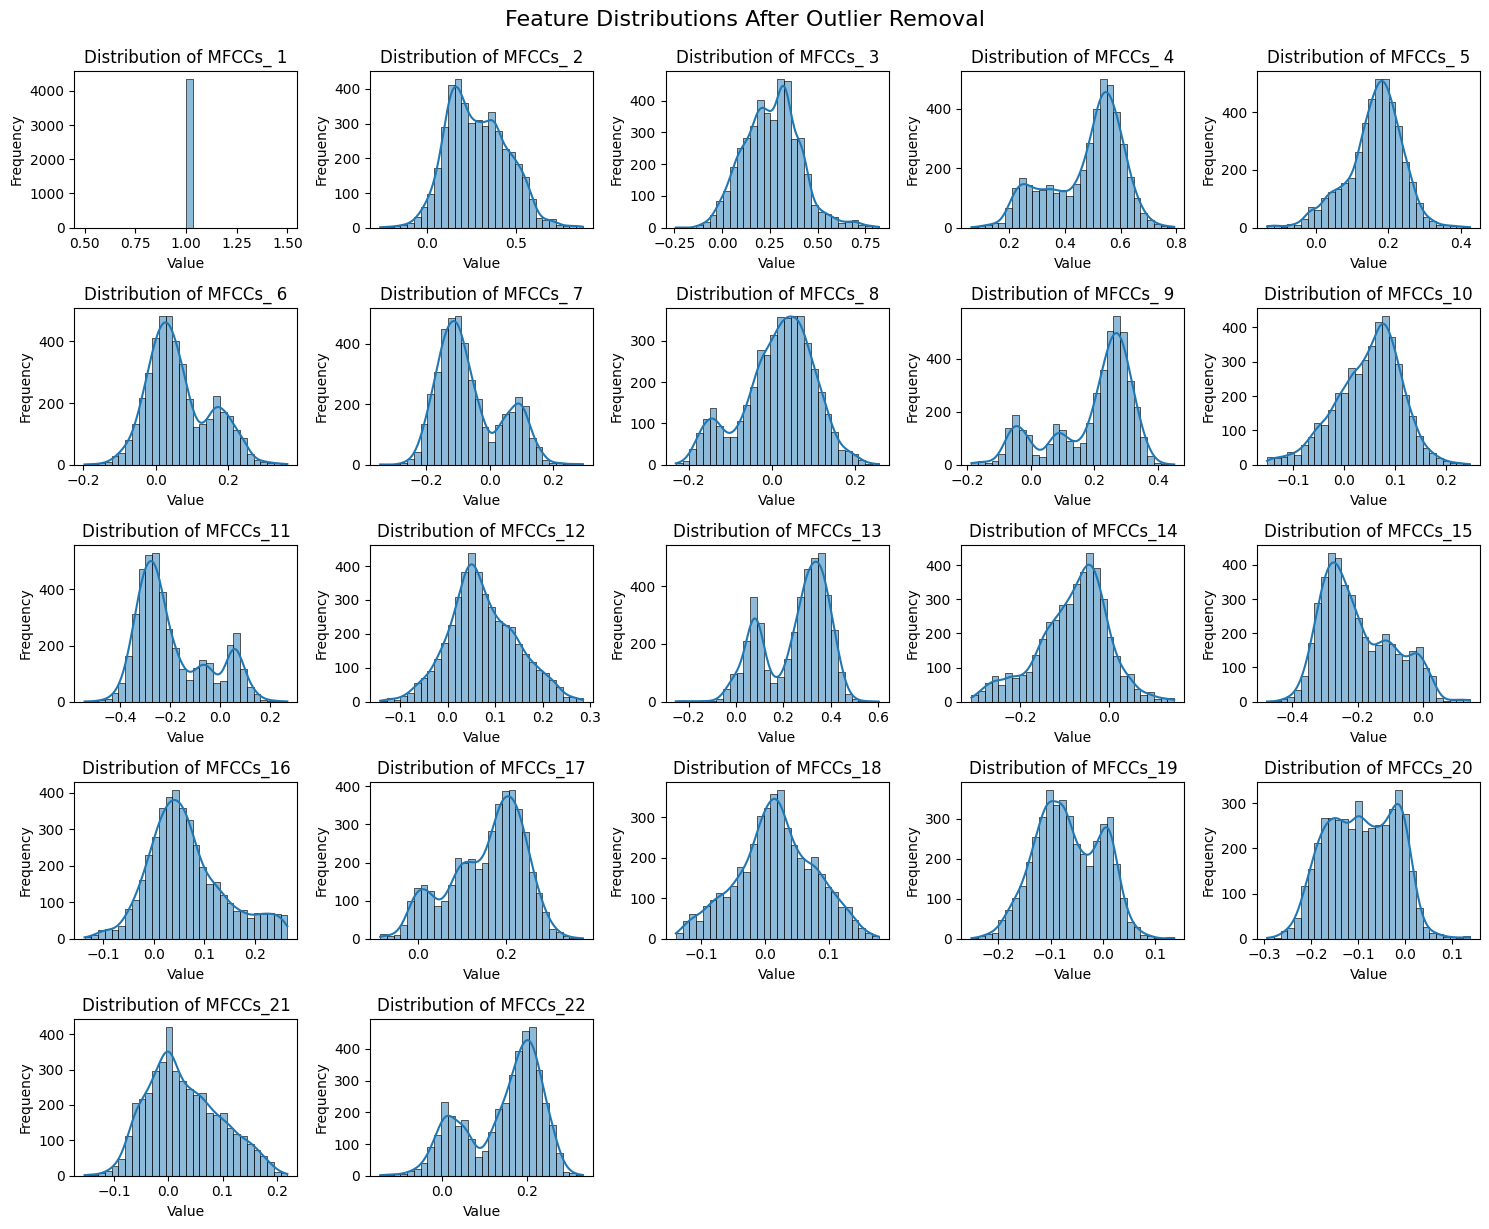


Data scaling to be done after doing Feature Correlation Analysis

Performing Feature Engineering...

After applying polynomial features the shape of Dataset is (4352, 275)

Analyzing Feature Correlations...


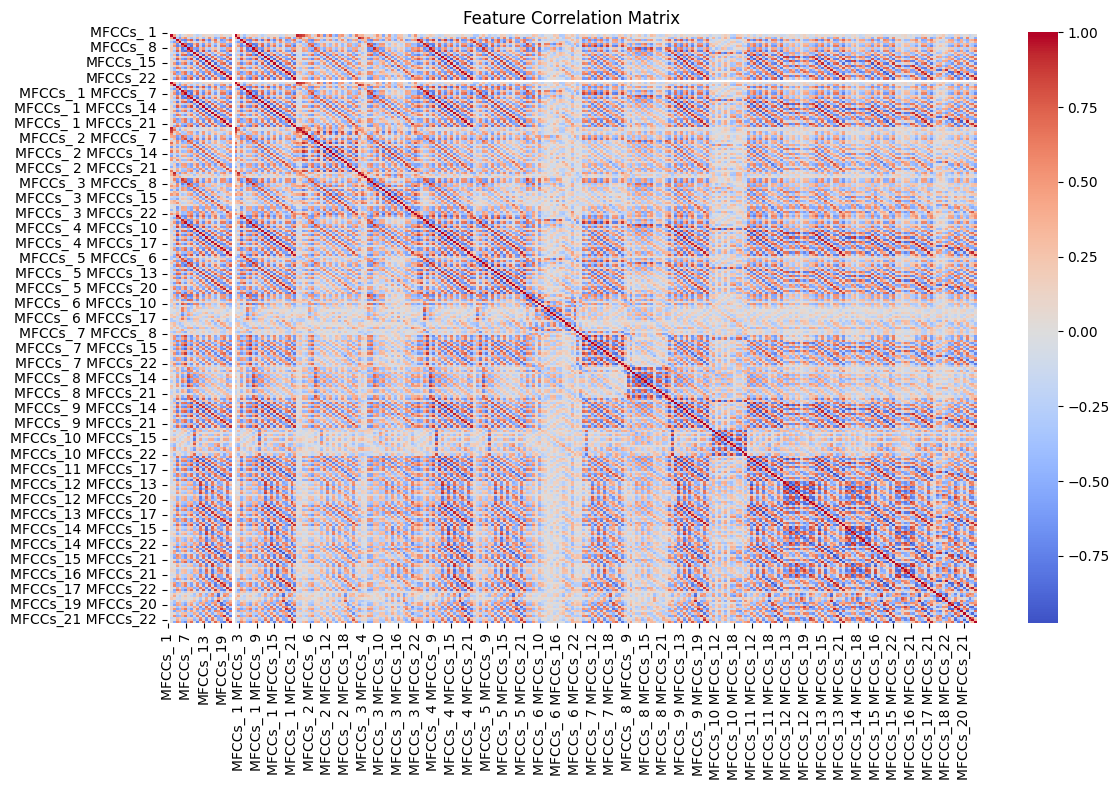


After removing highly correlated ones the shape of Dataset is: (4352, 199)

After applying Data scaling the shape of Dataset is: (4352, 199)


In [49]:
# Load the dataset
data = pd.read_csv('Frogs_MFCCs.csv')

# Step 1: Exploratory Data Analysis
print("\nPerforming EDA...")

# Check for missing values
print("\nMissing values in dataset:")
print(data.isnull().sum())

# Display basic statistics of features
print("\nBasic statistics of the dataset:")
print(data.describe())

# Select the 22 MFCC features
mfcc_features = [col for col in data.columns if col.startswith('MFCCs')]

# Plot Feature Distributions (before outlier removal)
plt.figure(figsize=(15, 12))
for i, feature in enumerate(mfcc_features, 1):
    plt.subplot(5, 5, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle("Feature Distributions Before Outlier Removal", y=1.02, fontsize=16)
plt.show()

print(f"Original dataset size: {data.shape[0]} rows")

# Remove Outliers using IQR method
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter data within the bounds
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Remove outliers from MFCC features
data = remove_outliers_iqr(data, mfcc_features)
print(f"Dataset size after outlier removal: {data.shape[0]} rows")

# Plot Feature Distributions (after outlier removal)
plt.figure(figsize=(15, 12))
for i, feature in enumerate(mfcc_features, 1):
    plt.subplot(5, 5, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle("Feature Distributions After Outlier Removal", y=1.02, fontsize=16)
plt.show()

print("\nData scaling to be done after doing Feature Correlation Analysis")

# Step 2: Feature Engineering
print("\nPerforming Feature Engineering...")

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
mfcc_cols = [col for col in data.columns if 'mfcc' in col.lower()]
poly_features = poly.fit_transform(data[mfcc_cols])
feature_names = poly.get_feature_names_out(mfcc_cols)
engineered_data = pd.DataFrame(poly_features, columns=feature_names)
print(f"\nAfter applying polynomial features the shape of Dataset is {engineered_data.shape}")

# Step 3: Feature Correlation Analysis
print("\nAnalyzing Feature Correlations...")

# Calculate and plot correlation matrix
correlation_matrix = engineered_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Remove highly correlated features (threshold = 0.95)
corr_matrix = engineered_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
final_data = engineered_data.drop(columns=to_drop)
print(f"\nAfter removing highly correlated ones the shape of Dataset is: {final_data.shape}")

# Step 4: Data Scaling
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(final_data), columns=final_data.columns)
print(f"\nAfter applying Data scaling the shape of Dataset is: {scaled_data.shape}")


In [50]:
###2.K-Means Clustering
print("\nStep 2: K-Means Clustering")


Step 2: K-Means Clustering


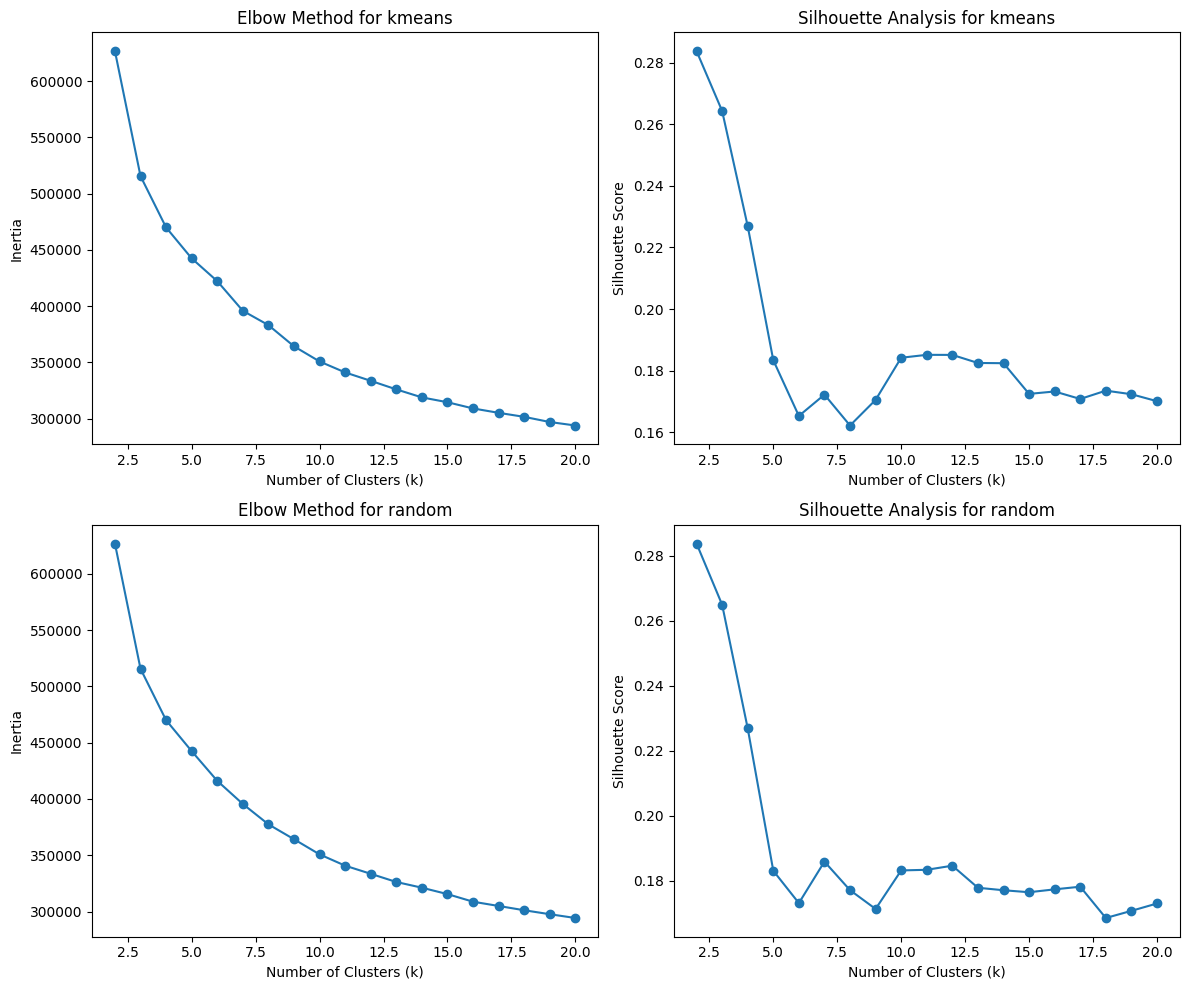


Comparing Initialization Methods...
Random Initialization Silhouette Score: 0.2838
K-means++ Initialization Silhouette Score: 0.2838

The best method is kmeans_plus


In [51]:
#Cluster initialization using both random-initialization and k-means++

max_clusters = 20

# Step 1: Implement Elbow Method using kmeans
inertias_kmeans = []
silhouette_scores_kmeans = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(scaled_data)
    inertias_kmeans.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(scaled_data, kmeans.labels_))

# Step 2: Implement Elbow method using random-initialisation

inertias_random = []
silhouette_scores_random = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k,init='random',random_state=42)
    kmeans.fit(scaled_data)
    inertias_random.append(kmeans.inertia_)
    silhouette_scores_random.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow Method for k-means++ and Silhouette Scores for k-means++
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for kmeans')

plt.subplot(2, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for kmeans')

# Plot Elbow Method for random and Silhouette Scores for random
plt.subplot(2, 2, 3)
plt.plot(range(2, max_clusters + 1), inertias_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for random')

plt.subplot(2, 2, 4)
plt.plot(range(2, max_clusters + 1), silhouette_scores_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for random')

plt.tight_layout()
plt.show()

# Choose optimal number of clusters (based on elbow method and silhouette scores of kmeans++)
optimal_clusters_kmeans = 2  # This should be adjusted based on the plots

# Choose optimal number of clusters (based on elbow method and silhouette scores of random)
optimal_clusters_random = 2  # This should be adjusted based on the plots

# Compare initialization methods
print("\nComparing Initialization Methods...")

# Random initialization
kmeans_random = KMeans(n_clusters=optimal_clusters_random, init='random', n_init=10, random_state=42)
kmeans_random.fit(scaled_data)
random_score = silhouette_score(scaled_data, kmeans_random.labels_)

# K-means++ initialization
kmeans_plus = KMeans(n_clusters=optimal_clusters_kmeans, init='k-means++', n_init=10, random_state=42)
kmeans_plus.fit(scaled_data)
plus_score = silhouette_score(scaled_data, kmeans_plus.labels_)

print(f"Random Initialization Silhouette Score: {random_score:.4f}")
print(f"K-means++ Initialization Silhouette Score: {plus_score:.4f}")

# Use the better performing initialization method
best_kmeans = kmeans_plus if plus_score >= random_score else kmeans_random
if best_kmeans == kmeans_plus :
    print("\nThe best method is kmeans_plus")
else :
    print("\nThe best method is kmeans_random")

In [52]:
###3.Cluster Visualization
print("\nStep 3: Cluster Visualization")


Step 3: Cluster Visualization


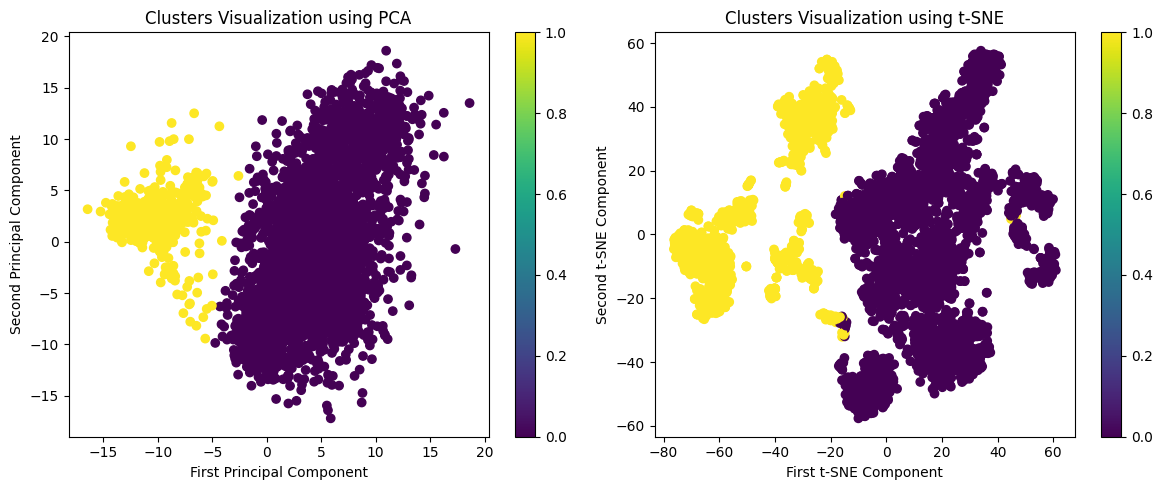

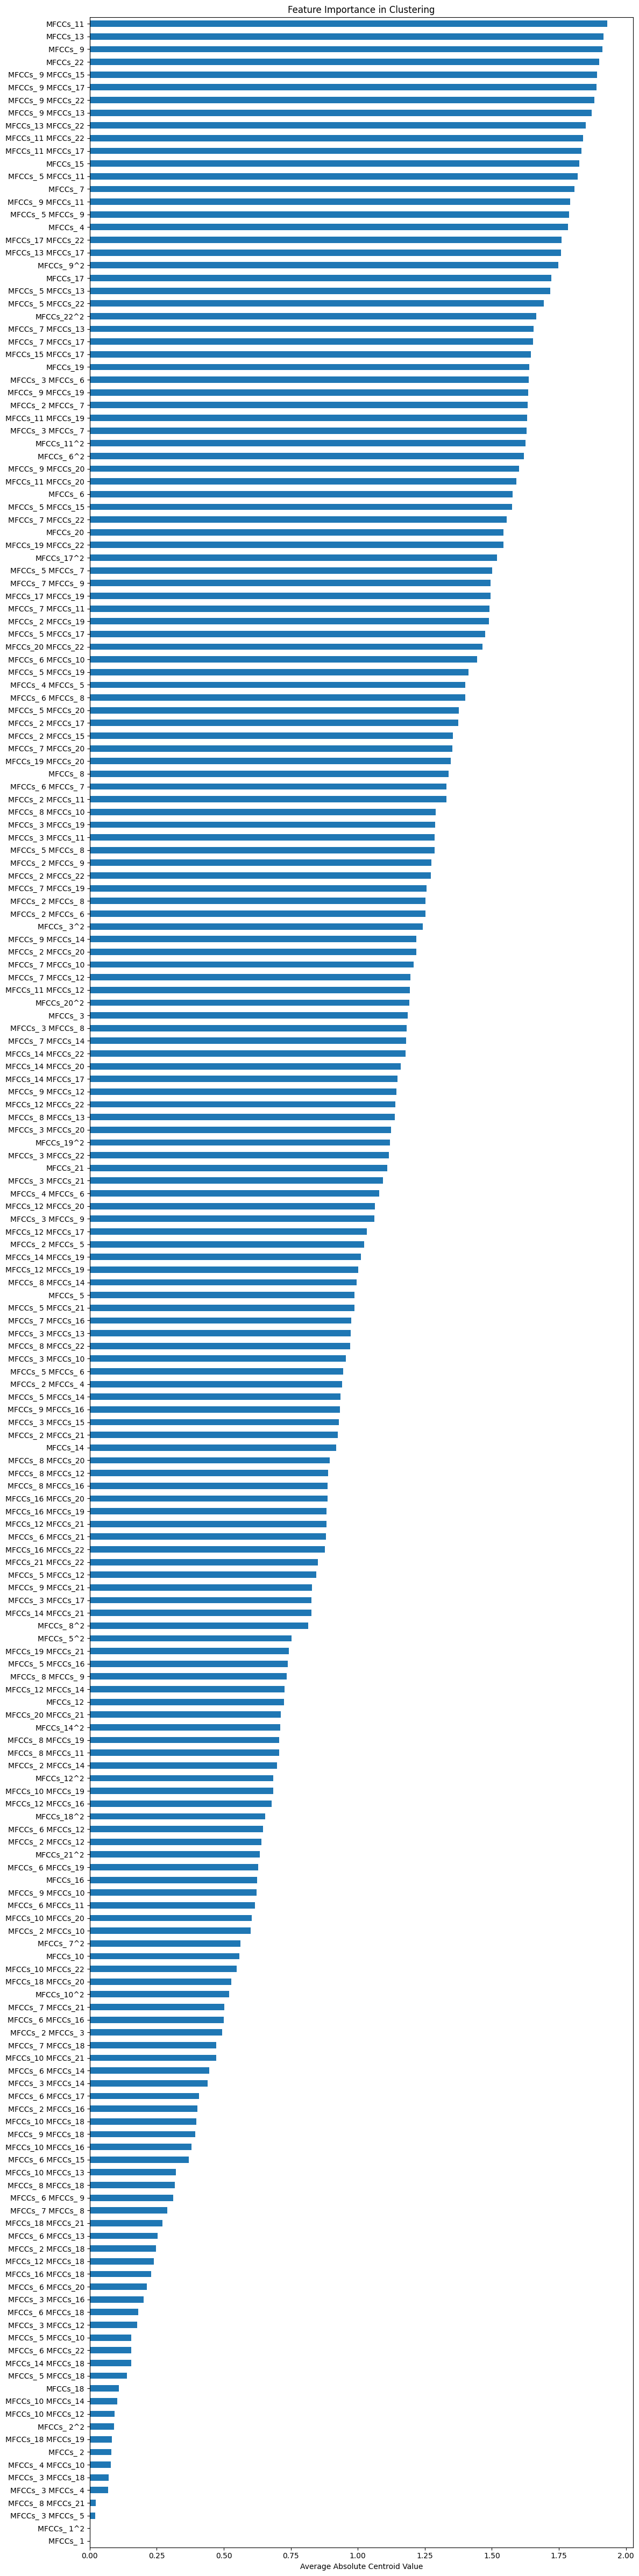

In [53]:
# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=best_kmeans.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clusters Visualization using PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=best_kmeans.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clusters Visualization using t-SNE')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.tight_layout()
plt.show()

# Analyze feature contribution to clustering
feature_importance = np.abs(best_kmeans.cluster_centers_).sum(axis=0)
feature_importance = pd.Series(feature_importance, index=scaled_data.columns)

plt.figure(figsize=(12,48))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Clustering')
plt.xlabel('Average Absolute Centroid Value')
plt.tight_layout()
plt.show()

In [54]:
###4.Cluster Evaluation Metrics
print("\nStep 4: Cluster Evaluation Metrics")


Step 4: Cluster Evaluation Metrics


Additional Clustering Evaluation Metrics:
Davies-Bouldin Index: 1.3201
Calinski-Harabasz Index: 1599.9569


Comparision of these metrics across different numbers of clusters to validate the Elbow Method and silhouette score results
by plotting the graphs of these metrics against different numbers of clusters



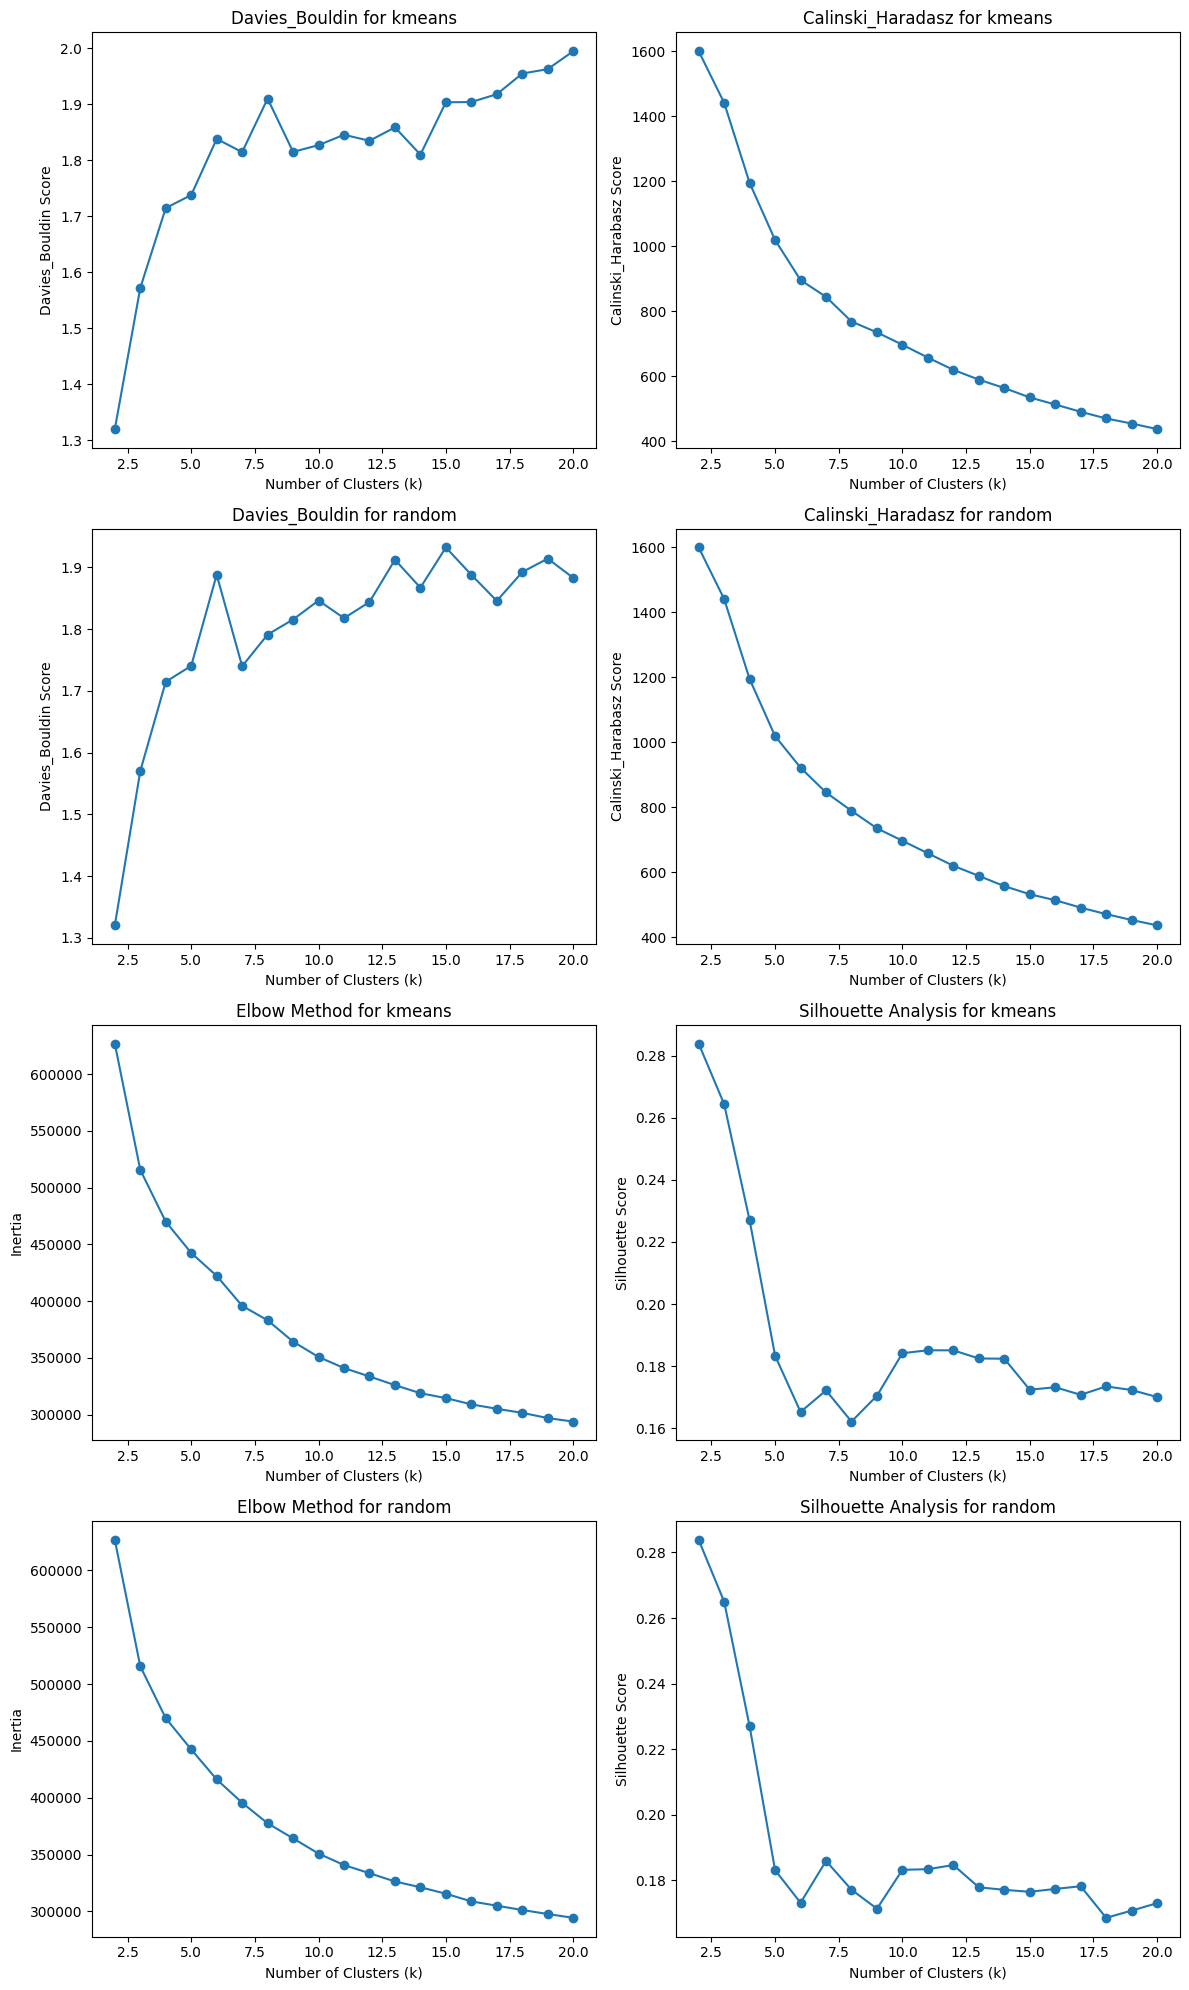

In [ ]:
# Calculate various clustering metrics
davies_bouldin = davies_bouldin_score(scaled_data, best_kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(scaled_data, best_kmeans.labels_)

print("Additional Clustering Evaluation Metrics:")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}\n")

print("\nComparision of these metrics across different numbers of clusters to validate the Elbow Method and silhouette score results")
print("by plotting the graphs of these metrics against different numbers of clusters\n")

davies_bouldin_kmeans = []
davies_bouldin_random = []

calinski_harabasz_kmeans = []
calinski_harabasz_random = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(scaled_data)
    davies_bouldin_kmeans.append(davies_bouldin_score(scaled_data,kmeans.labels_))
    calinski_harabasz_kmeans.append(calinski_harabasz_score(scaled_data, kmeans.labels_))

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k,init='random',random_state=42)
    kmeans.fit(scaled_data)
    davies_bouldin_random.append(davies_bouldin_score(scaled_data,kmeans.labels_))
    calinski_harabasz_random.append(calinski_harabasz_score(scaled_data, kmeans.labels_))


# Plot davies_bouldin for k-means++ and calinski_haradasz for k-means++
plt.figure(figsize=(12,20))
plt.subplot(4, 2, 1)
plt.plot(range(2, max_clusters + 1), davies_bouldin_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies_Bouldin Score')
plt.title('Davies_Bouldin for kmeans')

plt.subplot(4, 2, 2)
plt.plot(range(2, max_clusters + 1), calinski_harabasz_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski_Harabasz Score')
plt.title('Calinski_Haradasz for kmeans')

# Plot davies_bouldin for random and calinski_haradasz for random
plt.subplot(4, 2, 3)
plt.plot(range(2, max_clusters + 1), davies_bouldin_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies_Bouldin Score')
plt.title('Davies_Bouldin for random')

plt.subplot(4, 2, 4)
plt.plot(range(2, max_clusters + 1), calinski_harabasz_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski_Harabasz Score')
plt.title('Calinski_Haradasz for random')

# Plot Elbow Method for k-means++ and Silhouette Scores for k-means++
plt.subplot(4, 2, 5)
plt.plot(range(2, max_clusters + 1), inertias_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for kmeans')

plt.subplot(4, 2, 6)
plt.plot(range(2, max_clusters + 1), silhouette_scores_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for kmeans')

# Plot Elbow Method for random and Silhouette Scores for random
plt.subplot(4, 2, 7)
plt.plot(range(2, max_clusters + 1), inertias_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for random')

plt.subplot(4, 2, 8)
plt.plot(range(2, max_clusters + 1), silhouette_scores_random, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for random')

plt.tight_layout()
plt.show()

In [56]:
###5.Comparison with Other Clustering Algorithms
print("\nStep 5: Comparing with Other Clustering Algorithms")


Step 5: Comparing with Other Clustering Algorithms



Hierarchical Clustering Metrics:
Silhouette Score: 0.2830
Davies-Bouldin Index: 1.3277
Calinski-Harabasz Index: 1593.2522


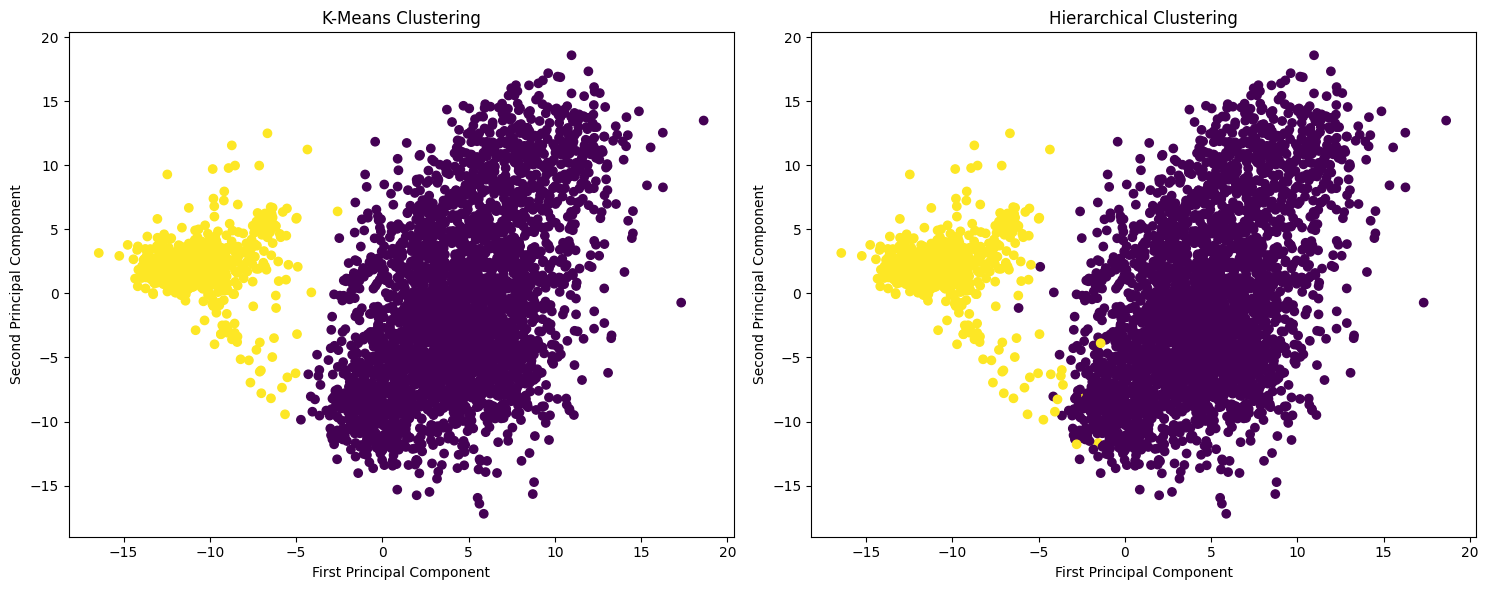


Analysis Summary:
1. Data preprocessing completed successfully
2. Optimal number of clusters: 2
3. K-means++ initialization performed better than random initialization
4. Both PCA and t-SNE visualizations provided
5. Comparison between K-means and Hierarchical clustering completed


In [57]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters_kmeans)
hierarchical_labels = hierarchical.fit_predict(scaled_data)

# Calculate metrics for hierarchical clustering
h_silhouette = silhouette_score(scaled_data, hierarchical_labels)
h_davies_bouldin = davies_bouldin_score(scaled_data, hierarchical_labels)
h_calinski_harabasz = calinski_harabasz_score(scaled_data, hierarchical_labels)

print("\nHierarchical Clustering Metrics:")
print(f"Silhouette Score: {h_silhouette:.4f}")
print(f"Davies-Bouldin Index: {h_davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {h_calinski_harabasz:.4f}")

# Visualize both clustering results
plt.figure(figsize=(15, 6))

# K-Means visualization
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=best_kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Hierarchical clustering visualization
plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

# Print final summary
print("\nAnalysis Summary:")
print("1. Data preprocessing completed successfully")
print(f"2. Optimal number of clusters: {optimal_clusters_kmeans}")
print("3. K-means++ initialization performed better than random initialization")
print("4. Both PCA and t-SNE visualizations provided")
print("5. Comparison between K-means and Hierarchical clustering completed")